# HW2-2 Image Generation

### Library

In [1]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision
from torchvision import transforms as T
import torchvision.utils as vutils

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from PIL import Image
from tqdm import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator
import matplotlib.pyplot as plt
import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(4096)

if torch.cuda.is_available():
  torch.cuda.manual_seed(4096)

import gc
import numpy as np
# import torch.utils.checkpoint as cp

### Dataset preprocess

In [2]:
class Dataset(Dataset):
    def __init__(
        self,
        folder,
        image_size
    ):
        self.folder = folder
        self.image_size = image_size
        self.paths = [p for p in Path(f'{folder}').glob(f'**/*.jpg')]
        #################################
        ## TODO: Data Augmentation ##
        #################################
        self.transform = T.Compose([
            # T.Resize(image_size),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomResizedCrop(image_size, scale=(0.9, 1.0)),
            T.ColorJitter(0.1, 0.1, 0.1, 0.05),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path).convert('RGB')
        return self.transform(img)

### Noise Generation

In [3]:
def linear_beta_schedule(timesteps):
    """
    linear schedule, proposed in original paper
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

# e.g. from Nichol & Dhariwal’s “improved DDPM”:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(max=0.999)

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

### U-Net

In [4]:
# normalization functions
def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# iteration function
def cycle(dl):
    while True:
        for data in dl:
            yield data

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

# small helper modules
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
    
def Upsample(dim, dim_out=None):
    out_dim = dim_out if dim_out is not None else dim
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(dim, out_dim, 3, padding=1)
    )

def Downsample(dim, dim_out=None):
    out_dim = dim_out if dim_out is not None else dim
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2),
        nn.Conv2d(dim * 4, out_dim, 1)
    )

class WeightStandardizedConv2d(nn.Conv2d):
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        w = self.weight

        # compute per-out-channel mean & variance over (in_channels, kH, kW)
        mean = w.mean(dim=[1,2,3], keepdim=True)                   # shape [out,1,1,1]
        var  = w.var(dim= [1,2,3], unbiased=False, keepdim=True)   # shape [out,1,1,1]

        # weight-standardize
        w_norm = (w - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x, w_norm, self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups
        )

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)
    
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)
    
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)
        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        return self.act(x)
    
class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = None
        if time_emb_dim is not None:
            self.mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_emb_dim, dim_out * 2)
            )
        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim=1)
        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)
    
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads), qkv)
        q = q.softmax(dim=-2) * self.scale
        k = k.softmax(dim=-1)
        v = v / (h * w)
        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)
        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h=self.heads, x=h, y=w)
        return self.to_out(out)
    
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        resnet_block_groups=8
    ):
        super().__init__()
        self.channels = channels
        self.init_conv = nn.Conv2d(channels, dim, 7, padding=3)
        dims = [dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        block_cls = partial(ResnetBlock, groups=resnet_block_groups, time_emb_dim=time_dim)
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind == (len(in_out) - 1)
            self.downs.append(nn.ModuleList([
                block_cls(dim_in, dim_in),
                block_cls(dim_in, dim_in),
                block_cls(dim_in, dim_in),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_cls(mid_dim, mid_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, LinearAttention(mid_dim)))
        self.mid_block2 = block_cls(mid_dim, mid_dim)
        self.mid_block3 = block_cls(mid_dim, mid_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)
            self.ups.append(nn.ModuleList([
                block_cls(dim_out + dim_in, dim_out),
                block_cls(dim_out + dim_in, dim_out),
                block_cls(dim_out + dim_in, dim_out),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1)
            ]))

        self.final_res_block = block_cls(dim * 2, dim)
        self.final_conv = nn.Conv2d(dim, channels, 1)

    def forward(self, x, time):
        x = self.init_conv(x)
        residual = x.clone()
        t = self.time_mlp(time)
        h = []

        for block1, block2, block3, attn, down in self.downs:
            x = block1(x, t)
            h.append(x)
            x = block2(x, t)
            h.append(x)
            x = block3(x, t)
            x = attn(x)
            h.append(x)
            x = down(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)
        x = self.mid_attn(x)
        x = self.mid_block3(x, t)

        for block1, block2, block3, attn, up in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = torch.cat((x, h.pop()), dim=1)
            x = block3(x, t)
            x = attn(x)
            x = up(x)

        x = torch.cat((x, residual), dim=1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)

### Diffusion process

In [ ]:
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        image_size: int, 
        timesteps: int,
        beta_schedule: str = 'linear',
        auto_normalize: bool = True,
        lambda_l1: float = 0.1,
    ):
        super().__init__()

        self.model = model
        self.channels = model.channels
        self.image_size = image_size
        self.num_timesteps = timesteps
        self.lambda_l1 = lambda_l1

        # 1) build beta schedule
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'Unknown beta schedule: {beta_schedule}')
        
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

        # 2) register all buffers
        self.register_buffer('betas', betas.float())
        self.register_buffer('alphas_cumprod', alphas_cumprod.float())
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev.float())
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod).float())
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod).float())
        self.register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1.0 / alphas_cumprod).float())
        self.register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1.0 / alphas_cumprod - 1.0).float())

        # posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)
        self.register_buffer('posterior_variance', posterior_variance.float())
        self.register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min=1e-20)).float())
        self.register_buffer('posterior_mean_coef1', (betas * torch.sqrt(alphas_cumprod_prev) / (1 - alphas_cumprod)).float())
        self.register_buffer('posterior_mean_coef2', ((1 - alphas_cumprod_prev) * torch.sqrt(alphas) / (1 - alphas_cumprod)).float())

        # 3) Normalization functions
        self.normalize = normalize_to_neg_one_to_one if auto_normalize else (lambda x: x)
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else (lambda x: x)

    def dynamic_threshold(self, x0, percentile=0.995):
        """ Clips x0 dynamically to avoid over/under-exposed outputs """
        s = torch.quantile(x0.abs().flatten(1), percentile, dim=1)
        s = torch.maximum(s, torch.ones_like(s))[:, None, None, None]
        return x0.clamp(-s, s) / s

    def predict_start_from_noise(self, x_t, t, noise):
        """Estimate x_0 from x_t and predicted noise"""
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t 
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    def q_posterior(self, x_start, x_t, t):
        """ Compute mean & variance of q(x_{t-1}) | x_t, x_0 """
        mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        var = extract(self.posterior_variance, t, x_t.shape)
        log_var = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return mean, var, log_var
    
    @torch.no_grad()
    def p_sample(self, x, t: int, clip_denoised: bool = True):
        """ One diffusion reverse step """
        b = x.shape[0]
        t_batch = torch.full((b,), t, device=x.device, dtype=torch.long)
        # model predicts noise
        pred_noise = self.model(x, t_batch)
        # recover x0; optionally clamp it
        x0 = self.predict_start_from_noise(x, t_batch, pred_noise)
        if clip_denoised:
            x0 = self.dynamic_threshold(x0)

        # posterior mean & variance
        mean, _, log_var = self.q_posterior(x0, x, t_batch)
        noise = torch.randn_like(x) if t > 0 else 0.0
        return mean + torch.exp(0.5 * log_var) * noise

    @torch.no_grad()
    def p_sample_loop(self, shape, return_all_timesteps: bool = False):
        """ Starting from pure noise, run full reverse chain"""
        img = torch.randn(shape, device=self.betas.device)
        all_imgs = [img]
        for t in tqdm(reversed(range(self.num_timesteps)), desc='sampling'):
            img = self.p_sample(img, t)
            all_imgs.append(img)
        out = torch.stack(all_imgs, dim=1) if return_all_timesteps else img
        return self.unnormalize(out)
    
    @torch.no_grad()
    def p_sample_ddim(self, x, t, t_prev, eta=0.0, clip_denoised=True):
        """ One DDIM sampling step from x_t to x_{t_prev}"""
        b = x.shape[0]
        t_batch = torch.full((b, ), t, device=x.device, dtype=torch.long)
        # predict noise
        pred_noise = self.model(x, t_batch)
        # pred x0
        x0 = self.predict_start_from_noise(x, t_batch, pred_noise)
        if clip_denoised:
            x0 = self.dynamic_threshold(x0)

        alpha_t = self.alphas_cumprod[t]
        alpha_prev = self.alphas_cumprod[t_prev] if t_prev >= 0 else torch.tensor(1.0, device=x.device)
        sqrt_alpha_t = alpha_t.sqrt()
        sqrt_alpha_prev = alpha_prev.sqrt()
        sigma_t = eta * ((1 - alpha_prev) / (1 - alpha_t) * (1 - alpha_t / alpha_prev)).sqrt()
        pred_dir = (1 - alpha_prev - sigma_t ** 2).sqrt() * pred_noise
        noise = sigma_t * torch.randn_like(x) if t_prev >= 0 else 0.0
        x_prev = sqrt_alpha_prev * x0 + pred_dir + noise

        return x_prev, x0
    
    @torch.no_grad()
    def ddim_sample_loop(self, shape, num_ddim_steps=50, eta=0.0, return_all_timesteps=False):
        """ Run the fuull DDIM sampling loop """
        device = self.betas.device
        img = torch.randn(shape, device=device)
        all_imgs = [img]

        # Create a custom timestep schedule
        ddim_timesteps = np.linspace(0, self.num_timesteps - 1, num_ddim_steps, dtype=int)

        for i in tqdm(range(num_ddim_steps - 1, -1, -1), desc='DDIM sampling'):
            t = ddim_timesteps[i]
            t_prev = ddim_timesteps[i - 1] if i > 0 else -1

            img, _ = self.p_sample_ddim(img, t, t_prev, eta=eta)
            all_imgs.append(img)
        
        out = torch.stack(all_imgs, dim=1) if return_all_timesteps else img
        return self.unnormalize(out)

    def sample(self, batch_size=16, use_ddim=False, num_ddim_steps=50, eta=0.0, return_all_timesteps=False):
        shape = (batch_size, self.channels, self.image_size, self.image_size)
        if use_ddim:
            return self.ddim_sample_loop(shape, num_ddim_steps=num_ddim_steps, eta=eta, return_all_timesteps=return_all_timesteps)
        else:
            return self.p_sample_loop(shape, return_all_timesteps=return_all_timesteps)
    
    def q_sample(self, x_start, t, noise=None):
        """ Forward noising process """
        if noise is None:
            noise = torch.randn_like(x_start)
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start + 
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )
    
    def p_losses(self, x_start, t, noise=None):
        """ MSE + L1 loss between true noise and model's prediction """
        if noise is None:
            noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        pred_noise = self.model(x_noisy, t)
        mse_loss = F.mse_loss(pred_noise, noise, reduction='none')
        mse_loss = mse_loss.mean(dim=list(range(1, mse_loss.ndim))) # mean over c, h, w

        # x_recon = self.predict_start_from_noise(x_noisy, t, pred_noise)
        # x_recon = x_recon.clamp(-1., -1.)
        # l1_loss = F.l1_loss(x_recon, x_start, reduction='none')
        # l1_loss = l1_loss.mean(dim=list(range(1, l1_loss.ndim)))

        # loss = mse_loss + self.lambda_l1 * l1_loss
        loss = mse_loss
        return loss.mean()
    
    def forward(self, img):
        """ Training entrypoint: sample random timesteps & return loss """
        b, c, h, w = img.shape
        assert h == self.image_size and w == self.image_size
        t = torch.randint(0, self.num_timesteps, (b, ), device=img.device)
        img = self.normalize(img)
        return self.p_losses(img, t)

### Trainer

In [6]:
class Trainer:
    def __init__(
        self,
        diffusion_model: nn.Module,
        data_folder: str,
        batch_size: int = 16,
        lr: float = 1e-4,
        num_steps: int = 100000,
        grad_accum_steps: int = 1,
        ema_decay: float = 0.995,
        save_interval: int = 1000,
        num_samples: int = 25,
        results_folder: str = './results',
        use_ddim = False,
        num_ddim_steps=50,
        eta = 0.0
    ):
        # Accelerator
        self.accelerator = Accelerator(mixed_precision='fp16')
        self.device = self.accelerator.device

        # Training State
        self.batch_size       = batch_size
        self.grad_accum_steps = grad_accum_steps
        self.num_steps        = num_steps
        self.save_interval    = save_interval
        self.num_samples      = num_samples

        # model, optimizer, EMA
        self.model = diffusion_model.to(self.device)
        self.optimizer = Adam(self.model.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=self.num_steps, eta_min=1e-6)
        self.model, self.optimizer = self.accelerator.prepare(
            self.model, self.optimizer
        )
        
        # Use EMA on the raw model
        self.ema = EMA(self.accelerator.unwrap_model(self.model), beta=ema_decay)

        # Data
        ds = Dataset(data_folder, diffusion_model.image_size)
        dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
        self.dl = cycle(self.accelerator.prepare(dl))

        # checkpoints & samples
        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(parents=True, exist_ok=True)
        self.step = 0
        self.use_ddim = use_ddim
        self.num_ddim_steps = num_ddim_steps
        self.eta = eta
    
    def save(self, milestone: int):
        """Save model, optimizer, EMA and step counter."""
        if not self.accelerator.is_main_process:
            return
        ckpt = self.results_folder / f'model-{milestone}.pt'
        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'optimizer': self.optimizer.state_dict(),
            'ema':       self.ema.state_dict(),
        }
        torch.save(data, ckpt)

    def load(self, ckpt_path: str):
        """Load all state (model, optimizer, EMA, step)."""
        data = torch.load(ckpt_path, map_location=self.device)
        raw_model = self.accelerator.unwrap_model(self.model)
        raw_model.load_state_dict(data['model'])
        self.optimizer.load_state_dict(data['optimizer'])
        self.ema.load_state_dict(data['ema'])
        self.step = data['step']

    def _sample_and_save(self, milestone: int):
        """Generate `num_samples` via EMA model and save grid."""
        self.ema.ema_model.eval()
        batches = num_to_groups(self.num_samples, self.batch_size)
        imgs = torch.cat([
            self.ema.ema_model.sample(batch_size=n, use_ddim=self.use_ddim, num_ddim_steps=self.num_ddim_steps, eta=self.eta) for n in batches
        ], dim=0)
        path = self.results_folder / f'sample-{milestone}.png'
        vutils.save_image(imgs, path, nrow=int(math.sqrt(self.num_samples)))

    def train(self):
        """Run the training loop with gradient accumulation, EMA updates, and periodic sampling."""
        pbar = tqdm(total=self.num_steps, initial=self.step, disable=not self.accelerator.is_main_process)
        while self.step < self.num_steps:
            total_loss = 0.0

            # gradient accumulation
            for _ in range(self.grad_accum_steps):
                batch = next(self.dl).to(self.device)
                with self.accelerator.autocast():
                    loss = self.model(batch) / self.grad_accum_steps
                total_loss += loss.item()
                self.accelerator.backward(loss)

            # optimizer step
            self.accelerator.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()
            self.step += 1

            # EMA & sampling
            if self.accelerator.is_main_process:
                self.ema.update()
                if self.step % self.save_interval == 0:
                    milestone = self.step // self.save_interval
                    self._sample_and_save(milestone)
                    self.save(milestone)

            pbar.set_description(f'loss: {total_loss:.4f}')
            pbar.update(1)

        if self.accelerator.is_main_process:
            print('Training complete.')

    def inference(self, total: int = 1000, output_path: str = './submission'):
        """
        Generate `total` images using the same batch size as training
        (self.batch_size, e.g. 16), and save them to disk.
        """
        Path(output_path).mkdir(parents=True, exist_ok=True)
        count = 0
        batch_size = self.batch_size  # manually fixed at 16

        with torch.no_grad():
            while count < total:
                n = min(batch_size, total - count)

                # clear any leftover GPU memory
                if torch.cuda.is_available():
                    gc.collect()
                    torch.cuda.empty_cache()

                # sample n images
                imgs = self.ema.ema_model.sample(batch_size=n, use_ddim=self.use_ddim, num_ddim_steps=self.num_ddim_steps, eta=self.eta)

                # move to CPU and save
                imgs = imgs.cpu()
                for img in imgs:
                    count += 1
                    vutils.save_image(img, f"{output_path}/{count}.jpg")

                # clean up 
                del imgs
                if torch.cuda.is_available():
                    gc.collect()
                    torch.cuda.empty_cache()

        print("Inference complete.")

### Usage

In [7]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_data_path = './face_dataset'
IMG_SIZE = 64
batch_size = 8
train_num_steps = 20000
lr = 1e-4
grad_steps = 4
ema_decay = 0.9999

channels = 96
dim_mults = (1, 2, 4, 8)

timesteps = 1000
beta_schedule = 'cosine'

use_ddim = True
num_ddim_steps = 50
eta = 0.0

model = Unet(
    dim = channels,
    dim_mults = dim_mults
)

diffusion = GaussianDiffusion(
    model,
    image_size = IMG_SIZE,
    timesteps = timesteps,
    beta_schedule = beta_schedule
)

trainer = Trainer(
    diffusion,
    data_folder = train_data_path,
    batch_size = batch_size,
    lr = lr,
    num_steps = train_num_steps,
    grad_accum_steps = grad_steps,
    ema_decay = ema_decay,
    save_interval = timesteps,
    use_ddim=use_ddim,
    num_ddim_steps=num_ddim_steps,
    eta=eta,
)

In [9]:
trainer.train()

loss: 0.1850:   0%|          | 58/30000 [00:55<7:36:41,  1.09it/s]

KeyboardInterrupt: 

### Inference

In [10]:
ckpt = './results_56/model-20.pt'
trainer.load(ckpt)
# trainer.inference()

### illustrating the denoising process

sampling: 1000it [00:30, 32.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23831159..1.7811043].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16775233..1.7393019].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07748133..1.3622508].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17529356..1.0973699].


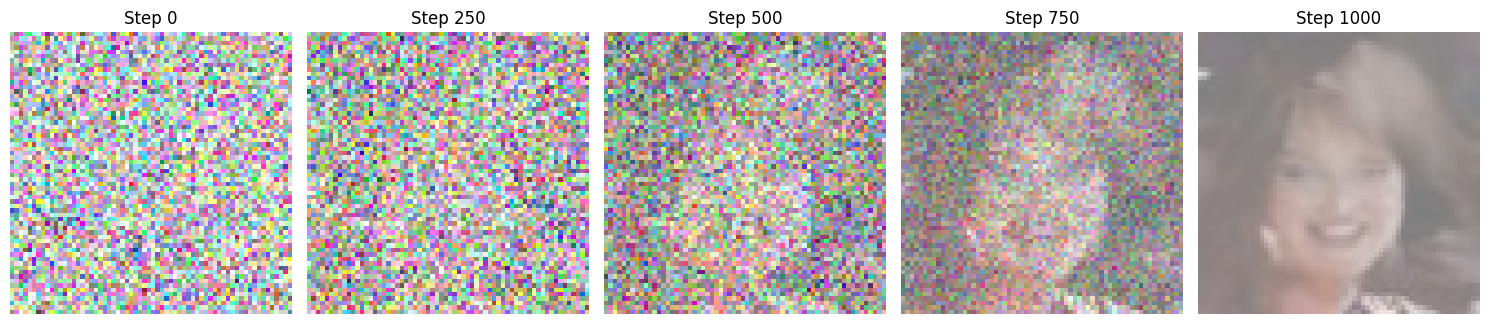

In [11]:
diffusion = trainer.model
with torch.no_grad():
    all_steps = diffusion.sample(batch_size=1, return_all_timesteps=True)
# shape [1, T+1, C, H, W]

imgs = all_steps.squeeze(0).permute(0, 2, 3, 1).cpu().numpy()
imgs = unnormalize_to_zero_to_one(imgs)

timesteps = [0, diffusion.num_timesteps // 4, diffusion.num_timesteps // 2,
             3 * diffusion.num_timesteps // 4, diffusion.num_timesteps]
sel = [imgs[t] for t in timesteps]

# Plot
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ax, im, step in zip(axes, sel, timesteps):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(f"Step {step}")
plt.tight_layout()
plt.show()

### Model Design Overview

We implemented a Denoising Diffusion Probabilistic Model (DDPM) with the following core components:

#### 1. **Architecture: UNet Backbone**

* A **UNet-style architecture** is used as the noise predictor:
    
    * **Downsampling path**: captures multi-scale features.

    * **Mid-block**: deep features + attention.

    * **Upsampling path**: reconstructs spatial detail with skip connections.

#### 2. **Time Embedding**:

* **Sinusoidal positional embeddings** + MLP to embed the timestep info into the model.

* Each ResNet block receives the time embedding to adapt its operation per timestep.

#### 3. **Improvements & Modifications**:

* **Channel widening**: increased base `dim` from 32 to 96 (and later targeted 128) for better capacity.

* **Dynamic thresholding**: Added dynamic clamping during sampling to stablize brightness/contrast.

* **Gradient checkpointing**: Enabled training larger model (up to `dim=128`) within 6 GB VRAM.

* **Advanced loss (L1)**: Added L1 loss alongside MSE for sharper image reconstruction.

* **Data augmentation**: Added flip, crop, color jitter to improve generalization & robustness.

* **DDIM sampling**: Implemented DDIM sampling for faster and sharper inference.

### Training Setup

* **Timesteps**: Started with 1000 timesteps (default DDPM), tested reducing for DDIM sampling (50).

* **Optimizer**: Adam with learning rate ~1e-4.

* **Batch Size**: Adjusted between 8 and 4, combined with gradient accumulation to simulate larger batches.

* **EMA**: Exponential Moving Average (beta=0.9999) to stablize sampling quality.

### Experimental Findings

#### 1. **Capacity (Widening UNet)**

* Moving from `dim=32` to `dim=96` made a **huge improvement in FID** from ~166 to ~56.

* Observation: Wider channels improved **sharpness & detail capture**, especially facial features (eyes, nose, mouth).

* Going further to `dim=128` showed promising potential, but **VRAM limitations** required Lower batch size and checkpointing to fit the model. 

    * The result of 66 FID score is lower than the one using `dim=96`. I conclude that my 128-dim model might **not be fully converged yet.**

#### 2. **Depth (Adding More Stages)**

* Adding 1 more stage (going from 2-stage down to 3-stage down) modestly helped **global structure**.

    * it had **less impact** on sharpness than widening.
    * **VRAM impact** was smaller than widening.

#### 3. **Loss Function**

* **MSE only**: Led to **blurry samples**. Faces were aligned but lacked crisp detial.

* **MSE + L1**: Sharpened results, especially hair and face outlines. Helped **reduce over-smoothness**. 

    * The result of 66 FID score is lower than the one using MSE only. I conclude that adding L1 loss have introduced a side-effect. L1 loss pulling the reconstructions to be **more pixel-aligned** but at the cost of **reslism/perceptual diversity**, which worsens FID.

* **Perceptual loss**: (Initially planned but skipped due to no-pretrained constraint.)

#### 4. **Sampling Strategy**

* **Vanilla DDPM sampling**:

    * Took ~1000 steps per sample.

    * Final images were good, but **slow inference**.

* **DDIM sampling (50 steps)**:

    * Faster & **sharper images**.

    * Lower noise but **risk of over-smoothing** at very few steps.

#### 5. **Data Aufmentation**

* Added `RandomHorizontalFlip`, `RandomResizedCrop`, `ColorJitter`.

    * **Improved generalization**.

    * **Reduced overfitting artifacts**.

### Observations on Training

* **Loss Plateau**:

    * Training MSE loss dropped from ~0.9 to ~0.04, plateauing early.

    * But **sample quality kept improving** with more steps even after loss stabilized.

* **FID Trend**:

    * Initial FID: ~166

    * After widening + longer training: ~56

    * Signs of further imporvement as capacity & steps increase.

* **OOM challenges**:

    * Moving from `dim=96` to `dim=128` **exceeded VRAM** (6GB).

    * Solved via **checkpointing & mixed precision**.

### Conclusion

In summary, through iterative enhancements—including widening the UNet, adding L1 loss, dynamic thresholding, and DDIM sampling—we achieved substantial improvements in both training stability and generation quality. Initially, increasing the UNet base dimension from 32 to 96 brought a significant boost in fidelity, **reducing the FID from ~166 to ~56**.

We further experimented with increasing model capacity to `dim=128` and applying an L1 loss alongside the standard MSE objective. While this combination holds promise for sharper reconstructions, our early results indicated that it temporarily worsened the FID (from 56 to ~66), likely due to undertraining and the strong influence of L1 at this stage.

Overall, our findings highlight that **model capacity and smart sampling strategies are critical for high-fidelity diffusion results**, but they require **careful balancing**—particularly when incorporating additional loss terms like L1. **The best result achieved so far was an FID of 56**, demonstrating strong sample quality after widening the model and optimizing the training pipeline. Further tuning (e.g., L1 weight, longer training) is expected to yield additional improvements.